In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from glob import glob
import numpy as np
from tqdm import tqdm

import networkx as nx
import networkx_temporal as tx
import nltk

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import leidenalg as la

In [55]:
highest_nest_df = pd.DataFrame()

for file in glob('D:/FV/Personal/VIU/clean_data/graph_metrics_*_clean.csv'):
    net_type = file.split('graph_metrics_')[-1].split('_clean')[0]
    graph_met = pd.read_csv(file, index_col=0)
    graph_met = graph_met[((graph_met.db == '9n') & 
                    (graph_met.hour <= 437059) & 
                    (graph_met.hour >= 436998)) |
              ((graph_met.db != '9n') & 
                    (graph_met.hour >= 429534) & 
                    (graph_met.hour <= 429694)) ]
    hour_no = graph_met[(graph_met.db == 'no') & (graph_met.nest == graph_met[(graph_met.db == 'no')].nest.max()) ].hour[0]
    hour_9n = graph_met[(graph_met.db != 'no') & (graph_met.nest == graph_met[(graph_met.db != 'no')].nest.max()) ].hour[0]

    highest_nest_df = pd.concat([highest_nest_df,pd.DataFrame([[net_type, 'no', hour_no],
                                    [net_type, '9n', hour_9n]])])
    
highest_nest_df.columns = ['net_type', 'db','hour']

# highest_nest_df['db'] = highest_nest_df.db.replace('no', 'noAlt') 

highest_nest_df.sort_values('db')

,net_type,db,hour
1,bipartite,9n,437037
1,bipartite_trimed,9n,437037
1,hashNodes,9n,437045
1,userNodes,9n,437037
0,bipartite,no,429624
0,bipartite_trimed,no,429624
0,hashNodes,no,429624
0,userNodes,no,429624


In [56]:
dates_path = 'D:/FV/Personal/VIU/clean_data/graph_metrics_bipartite_trimed_clean.csv'

dates = pd.read_csv(dates_path, index_col=0)

dates = dates[((dates.db == '9n') & 
                    (dates.hour <= 437059) & 
                    (dates.hour >= 436998)) |
              ((dates.db != '9n') & 
                    (dates.hour >= 429534) & 
                    (dates.hour <= 429694)) ]

dates_9n = dates[dates.db == '9n']
dates_no = dates[dates.db != '9n']


dates = pd.concat([dates_9n.loc[(dates_9n.total_nr_of_nodes > 0.15*dates_9n.total_nr_of_nodes.max()), :] , 
                   dates_no.loc[(dates_no.total_nr_of_nodes > 0.15*dates_no.total_nr_of_nodes.max()), :]])


In [74]:
node_freq_path = 'D:/FV/Personal/VIU/clean_data/node_freq_per_hour.pickle'
# node_freq_path = 'D:/FV/Personal/VIU/clean_data/node_freq_comm_per_hour_nodeFreqLargerThan2.pickle'

with open(node_freq_path, 'rb') as handle:
    node_freq_df = pickle.load(handle).convert_dtypes()

node_freq_df['hour'] = node_freq_df.hour.astype(int)

node_freq_df['node'] = node_freq_df.node.astype(str)

node_freq_df['db'] = node_freq_df.db.replace('noAlt', 'no')

node_freq_df

,node_type,node,freq,db,hour,hash_comp,hash_comp_size,user_comp,user_comp_size,bip_comp,bip_comp_size
0,hashtag,bolivia,171,9n,436984,0,375,<NA>,<NA>,0,918
1,hashtag,9ngranmarchaporlajusticia,116,9n,436984,0,375,<NA>,<NA>,0,918
2,hashtag,lacuevadeofelia,82,9n,436984,0,375,<NA>,<NA>,0,918
3,hashtag,cambiosparasiempre,82,9n,436984,0,375,<NA>,<NA>,0,918
4,hashtag,buenjueves,63,9n,436984,0,375,<NA>,<NA>,0,918
...,...,...,...,...,...,...,...,...,...,...,...
628,hashtag,lavagadecabal,1,no,429790,12,5,<NA>,<NA>,13,6
629,user,258925451,1,no,429790,<NA>,<NA>,<NA>,<NA>,80,2
630,user,256188370,1,no,429790,<NA>,<NA>,18,2,29,3
631,hashtag,leninmoreno,1,no,429790,<NA>,<NA>,<NA>,<NA>,79,2


# Temoporal community detection

In [37]:


link_list_path = 'D:/FV/Personal/VIU/clean_data/link_lists_after_cleaning/*{}_link_list.pickle'.format(str_identifier)

def get_temporal_graphs(link_list_path, str_identifier):

    link_lists = glob(link_list_path)

    graphs_9n = {}
    graphs_noAlt = {}


    for file_path in tqdm(link_lists):
        if '.csv' in file_path:
            continue

        hour = int(file_path.split('_link_list.pickle')[0].split('_')[-2])
        database = file_path.split('\\')[-1].split('_')[0]
        
        with open(file_path, 'rb') as f:
            link_list = pickle.load(f)

        if str_identifier == 'bipartite': # Trimming network
            hash_count = pd.DataFrame(link_list).groupby(1).size()
            hash_only_used_by_one_user = hash_count[hash_count==1].index
            clean_link_list = [link for link in link_list if link[1] not in hash_only_used_by_one_user]
        else:
            clean_link_list = [tup for tup in link_list if tup[2] != 0]

        clean_link_list = [(str(link[0]), str(link[1]), link[2]) for link in clean_link_list]
        clean_link_arr = np.array(clean_link_list)
        nodes = np.concatenate([clean_link_arr[:,0], clean_link_arr[:,1]])

        G = nx.Graph()
        G.add_weighted_edges_from(clean_link_list)

        # get components
        components = sorted(nx.connected_components(G), key=len, reverse=True)
        components = [list(comp) for comp in components]

        G_sub = G.subgraph(components[0])

        # Get database
        if database == '9n':
            graphs_9n[hour] = G
            # graphs_9n[hour] = G_sub
            graphs_9n[hour].name = hour

        elif database == 'no':
            graphs_noAlt[hour] = G
            # graphs_noAlt[hour] = G_sub
            graphs_noAlt[hour].name = hour
        

    def get_temporal_graph(graphs):
        hour_dics = {sorted(list(graphs.keys()))[p]:p for p in range(len(graphs.keys()))}
        for key, value in graphs.items():
            value.name = key
            graphs[key] = value
        tg = tx.from_snapshots({hour_dics[key]:value for key, value in graphs.items()})

        return tg


    # Create temporal graph from snapshots.

    tg_9n = get_temporal_graph(graphs_9n)
    tg_noAlt = get_temporal_graph(graphs_noAlt)

    return tg_9n, tg_noAlt



In [38]:
def get_temporal_communities(tg_graph):
    temporal_opts = {}

    temporal_membership, improvement = la.find_partition_temporal(
        tg_graph.to_snapshots("igraph"),
        la.ModularityVertexPartition,
        interslice_weight=1.0,
        n_iterations=-1,
        seed=0,
        vertex_id_attr="_nx_name"
    )

    hours = [g.name for g in tg_graph]

    tg_comms_df = pd.DataFrame()

    for p in range(len(hours)):
        g = tg_graph[p]
        hour = g.name
        nodes = list(g.nodes())
        node_comm_dic = {}
        for q in range(len(nodes)):
            node_comm_dic[nodes[q]] = temporal_membership[p][q]
        hour_df = pd.DataFrame().from_dict(node_comm_dic, orient='index').reset_index()
        hour_df.columns = ['node', 'tg_com']
        hour_df['hour'] = hour
        tg_comms_df = pd.concat([tg_comms_df, hour_df])

    tg_comms_df['node'] = tg_comms_df.node.astype(str)

    return tg_comms_df

In [39]:
str_identifier = 'bipartite'
# str_identifier = 'hashNodes'
# str_identifier = 'userNodes'

tg_comms_df = pd.DataFrame()
for str_identifier in tqdm(['bipartite', 'hashNodes', 'userNodes']):

    tg_9n, tg_noAlt = get_temporal_graphs(link_list_path, str_identifier)

    tg_comms_9n_df = get_temporal_communities(tg_9n)
    tg_comms_9n_df['db'] = '9n'

    tg_comms_noAlt_df = get_temporal_communities(tg_noAlt)
    tg_comms_noAlt_df['db'] = 'no'

    tg_comms_net_df = pd.concat([tg_comms_9n_df, tg_comms_noAlt_df]).reset_index(drop = True)
    tg_comms_net_df['net_type'] = str_identifier

    tg_comms_df = pd.concat([tg_comms_df, tg_comms_net_df])

100%|██████████| 3/3 [1:30:42<00:00, 1814.08s/it]


In [40]:
tg_comms_df.to_csv('D:/FV/Personal/VIU/clean_data/temporal_communities.csv')

In [69]:
tg_comms_df = pd.read_csv('D:/FV/Personal/VIU/clean_data/temporal_communities.csv', index_col = 0)
tg_comms_df

,node,tg_com,hour,db,net_type
0,1227461558,40,436984,9n,bipartite
1,riquelme,40,436984,9n,bipartite
2,1184163754847682565,13,436984,9n,bipartite
3,ddm,13,436984,9n,bipartite
4,766428376043286528,16,436984,9n,bipartite
...,...,...,...,...,...
257891,574945793,58,429790,no,userNodes
257892,564184537,2267,429790,no,userNodes
257893,guaido233,2267,429790,no,userNodes
257894,550156195,4,429790,no,userNodes


In [73]:
node_freq_df

,node_type,node,freq,db,hour,hash_comp,hash_comp_size,user_comp,user_comp_size,bip_comp,bip_comp_size
0,hashtag,bolivia,171,9n,436984,0,375,<NA>,<NA>,0,918
1,hashtag,9ngranmarchaporlajusticia,116,9n,436984,0,375,<NA>,<NA>,0,918
2,hashtag,lacuevadeofelia,82,9n,436984,0,375,<NA>,<NA>,0,918
3,hashtag,cambiosparasiempre,82,9n,436984,0,375,<NA>,<NA>,0,918
4,hashtag,buenjueves,63,9n,436984,0,375,<NA>,<NA>,0,918
...,...,...,...,...,...,...,...,...,...,...,...
628,hashtag,lavagadecabal,1,noAlt,429790,12,5,<NA>,<NA>,13,6
629,user,258925451,1,noAlt,429790,<NA>,<NA>,<NA>,<NA>,80,2
630,user,256188370,1,noAlt,429790,<NA>,<NA>,18,2,29,3
631,hashtag,leninmoreno,1,noAlt,429790,<NA>,<NA>,<NA>,<NA>,79,2


In [78]:
df

,node_type,node,freq,db,hour,hash_comp,hash_comp_size,user_comp,user_comp_size,bip_comp,bip_comp_size,tg_com,net_type,tg_com_size,y_coord
0,hashtag,9ngranmarchaporlajusticia,88,9n,437001,0,224,<NA>,<NA>,0,469,1,hashNodes,51,0
1,hashtag,9njusticiaya,63,9n,437001,0,224,<NA>,<NA>,0,469,1,hashNodes,51,1
2,hashtag,bastababy,62,9n,437001,0,224,<NA>,<NA>,0,469,13,hashNodes,33,bastababy
3,hashtag,lulalivre,48,9n,437001,0,224,<NA>,<NA>,0,469,2,hashNodes,78,lulalivre
4,hashtag,9njusticia,46,9n,437001,0,224,<NA>,<NA>,0,469,3,hashNodes,29,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75519,user,313578664,1,9n,437059,<NA>,<NA>,0,721,0,1203,0,hashNodes,240,313578664
75520,user,3940673836,1,9n,437059,<NA>,<NA>,0,721,0,1203,0,hashNodes,240,3940673836
75521,hashtag,elclubdelpueblo,1,9n,437059,<NA>,<NA>,<NA>,<NA>,56,2,342,hashNodes,2,elclubdelpueblo
75522,hashtag,noalindulto,1,9n,437059,0,482,<NA>,<NA>,0,1203,4,hashNodes,96,noalindulto


In [80]:
reference_nodes

{'9ngranmarchaporlajusticia': 0,
 '9njusticiaya': 1,
 '9njusticia': 2,
 'bolivia': 3,
 '9nyovoy': 4,
 '9n': 5,
 'urgente': 6,
 'comodoropy': 7,
 'evonoestassolo': 8,
 '9nmarchaporlajusticia': 9,
 '9nov': 10,
 'queremosdesafuero': 11,
 'estoreciencomienza': 12,
 'defensoresdelcambio': 13,
 'grupodepuebla': 14,
 'boliviadijono': 15,
 'fichalimpialovamosalograr': 16,
 'evorenunciaya': 17,
 'estorecienempieza': 18,
 'larebeliondelosmansos': 19}

In [79]:
reference_nodes_dec

{0: '9ngranmarchaporlajusticia',
 1: '9njusticiaya',
 2: '9njusticia',
 3: 'bolivia',
 4: '9nyovoy',
 5: '9n',
 6: 'urgente',
 7: 'comodoropy',
 8: 'evonoestassolo',
 9: '9nmarchaporlajusticia',
 10: '9nov',
 11: 'queremosdesafuero',
 12: 'estoreciencomienza',
 13: 'defensoresdelcambio',
 14: 'grupodepuebla',
 15: 'boliviadijono',
 16: 'fichalimpialovamosalograr',
 17: 'evorenunciaya',
 18: 'estorecienempieza',
 19: 'larebeliondelosmansos'}

In [82]:
node_freq_and_tgComms_df

,node_type,node,freq,db,hour,hash_comp,hash_comp_size,user_comp,user_comp_size,bip_comp,bip_comp_size,tg_com,net_type,tg_com_size
0,hashtag,bolivia,171,9n,436984,0,375,<NA>,<NA>,0,918,0,hashNodes,110
1,hashtag,9ngranmarchaporlajusticia,116,9n,436984,0,375,<NA>,<NA>,0,918,1,hashNodes,91
2,hashtag,lacuevadeofelia,82,9n,436984,0,375,<NA>,<NA>,0,918,10,hashNodes,76
3,hashtag,cambiosparasiempre,82,9n,436984,0,375,<NA>,<NA>,0,918,16,hashNodes,88
4,hashtag,buenjueves,63,9n,436984,0,375,<NA>,<NA>,0,918,34,hashNodes,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125647,user,2889174727,1,9n,437080,<NA>,<NA>,<NA>,<NA>,61,2,6,hashNodes,38
125648,hashtag,nosomoslosmismos,1,9n,437080,0,326,<NA>,<NA>,0,768,9,hashNodes,33
125649,user,2806414367,1,9n,437080,<NA>,<NA>,0,442,0,768,2,hashNodes,76
125650,hashtag,noraperle,1,9n,437080,12,2,<NA>,<NA>,23,3,1030,hashNodes,3


In [ ]:
import matplotlib as mpl

def plot_Node_freq(tg_comms_df):

    node_freq_and_tgComms_df = node_freq_df.merge(tg_comms_df, on=['hour', 'node', 'db'])


    tmp = node_freq_and_tgComms_df.groupby(['hour', 'tg_com']).size().reset_index().rename(columns={0:'tg_com_size'})
    node_freq_and_tgComms_df =  node_freq_and_tgComms_df.merge(tmp, on=['hour', 'tg_com'])

    print(node_freq_and_tgComms_df)

    pd.set_option('future.no_silent_downcasting', True)
    if 'bipartite' in net_type:
        nodes = ['hashtag', 'user']
        comp_col = 'bip_community'
    elif net_type == 'hashNodes':
        nodes = ['hashtag']
        comp_col = 'tg_com'
    else:
        nodes = ['user']
        comp_col = 'user_community'
        
    n_top_nodes = 20

    hour = highest_nest_df.loc[(highest_nest_df.net_type == 'bipartite_trimed') &
                            (highest_nest_df.db == db), 'hour'].iloc[0]

    reference_nodes_dec = node_freq_and_tgComms_df.loc[node_freq_and_tgComms_df.node_type.isin(nodes) &
                            (node_freq_and_tgComms_df.db == db) &
                            (node_freq_and_tgComms_df.hour == hour), : ].sort_values('freq', 
                                            ascending = False).reset_index(drop=True)['node'][:n_top_nodes].to_dict()

    reference_nodes = {y: x for x, y in reference_nodes_dec.items()}



    def get_node_freq_community_per_hour(group):
        group = group.sort_values(comp_col+'_size', ascending=False).reset_index().rename(columns={'index':'order_' + comp_col})
        return group.loc[group.node.isin(reference_nodes.keys()), ['node','node_type', 'freq', 'tg_com', 'tg_com_size']]

    df = node_freq_and_tgComms_df.loc[(node_freq_and_tgComms_df.db == db) &
                        (node_freq_and_tgComms_df.hour.isin(dates.hour.tolist() + [hour])), 
                        :].groupby('hour').apply(lambda g: get_node_freq_community_per_hour(g)).reset_index().drop(columns = 'level_1')
    df = df.dropna(subset=comp_col, ).reset_index(drop=True)

    df['y_coord'] = df.node.replace(reference_nodes)
    df[comp_col] = df[comp_col].astype(object)
    df['hour'] = df['hour'].astype(int)
    df['y_coord'] = df['y_coord'].astype(int)
    df['freq'] = df['freq'].astype(int)


    df['comp'] = df['tg_com']

    fig, ax = plt.subplots(1,1, figsize = [10, 4])

    sns.scatterplot(data = df, 
                    x = 'hour', y = 'y_coord', 
                    hue = 'comp',
                    style='node_type', size='freq', 
                    sizes=(10, 200), legend=False,
                    palette = 'tab20',
                    ax = ax,
                    alpha =.9)

    ax.ticklabel_format(useOffset=False)
    ax.set_yticks(np.arange(20));

    tick_labels = [reference_nodes_dec[p] for p in range(20)]

    new_xticklabels = [pd.to_datetime( int(hour.get_text()) * 3600, unit='s').strftime('%m-%d %H') for hour in ax.get_xticklabels()]

    ax.set_xticklabels(new_xticklabels);
    ax.set_yticklabels(tick_labels);
    ax.set_ylabel('nodes')

In [87]:
node_freq_and_tgComms_df

,node_type,node,freq,db,hour,hash_comp,hash_comp_size,user_comp,user_comp_size,bip_comp,bip_comp_size,tg_com,net_type,tg_com_size
0,hashtag,bolivia,171,9n,436984,0,375,<NA>,<NA>,0,918,0,hashNodes,110
1,hashtag,9ngranmarchaporlajusticia,116,9n,436984,0,375,<NA>,<NA>,0,918,1,hashNodes,91
2,hashtag,lacuevadeofelia,82,9n,436984,0,375,<NA>,<NA>,0,918,10,hashNodes,76
3,hashtag,cambiosparasiempre,82,9n,436984,0,375,<NA>,<NA>,0,918,16,hashNodes,88
4,hashtag,buenjueves,63,9n,436984,0,375,<NA>,<NA>,0,918,34,hashNodes,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125647,user,2889174727,1,9n,437080,<NA>,<NA>,<NA>,<NA>,61,2,6,hashNodes,38
125648,hashtag,nosomoslosmismos,1,9n,437080,0,326,<NA>,<NA>,0,768,9,hashNodes,33
125649,user,2806414367,1,9n,437080,<NA>,<NA>,0,442,0,768,2,hashNodes,76
125650,hashtag,noraperle,1,9n,437080,12,2,<NA>,<NA>,23,3,1030,hashNodes,3


In [91]:
df = node_freq_and_tgComms_df.loc[(node_freq_and_tgComms_df.db == db) &
                            (node_freq_and_tgComms_df.hour.isin(dates.hour.tolist() + [hour])), 
                            :]
df = df.dropna(subset=comp_col, ).reset_index(drop=True)
df


,node_type,node,freq,db,hour,hash_comp,hash_comp_size,user_comp,user_comp_size,bip_comp,bip_comp_size,tg_com,net_type,tg_com_size
0,hashtag,9ngranmarchaporlajusticia,88,9n,437001,0,224,<NA>,<NA>,0,469,1,hashNodes,51
1,hashtag,9njusticiaya,63,9n,437001,0,224,<NA>,<NA>,0,469,1,hashNodes,51
2,hashtag,bastababy,62,9n,437001,0,224,<NA>,<NA>,0,469,13,hashNodes,33
3,hashtag,lulalivre,48,9n,437001,0,224,<NA>,<NA>,0,469,2,hashNodes,78
4,hashtag,9njusticia,46,9n,437001,0,224,<NA>,<NA>,0,469,3,hashNodes,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75519,user,313578664,1,9n,437059,<NA>,<NA>,0,721,0,1203,0,hashNodes,240
75520,user,3940673836,1,9n,437059,<NA>,<NA>,0,721,0,1203,0,hashNodes,240
75521,hashtag,elclubdelpueblo,1,9n,437059,<NA>,<NA>,<NA>,<NA>,56,2,342,hashNodes,2
75522,hashtag,noalindulto,1,9n,437059,0,482,<NA>,<NA>,0,1203,4,hashNodes,96


C:\Users\neuro\AppData\Local\Temp\ipykernel_20968\973017618.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y_coord'] = df.node.replace(reference_nodes)
C:\Users\neuro\AppData\Local\Temp\ipykernel_20968\973017618.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['hour'].astype(int)
C:\Users\neuro\AppData\Local\Temp\ipykernel_20968\973017618.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

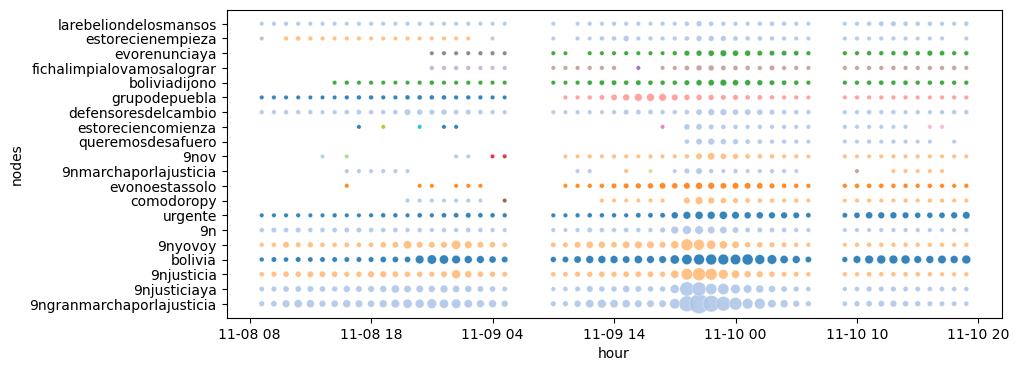

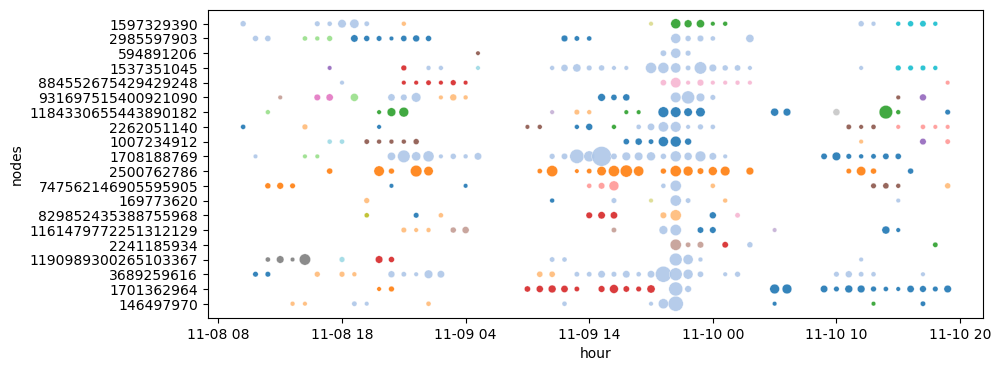

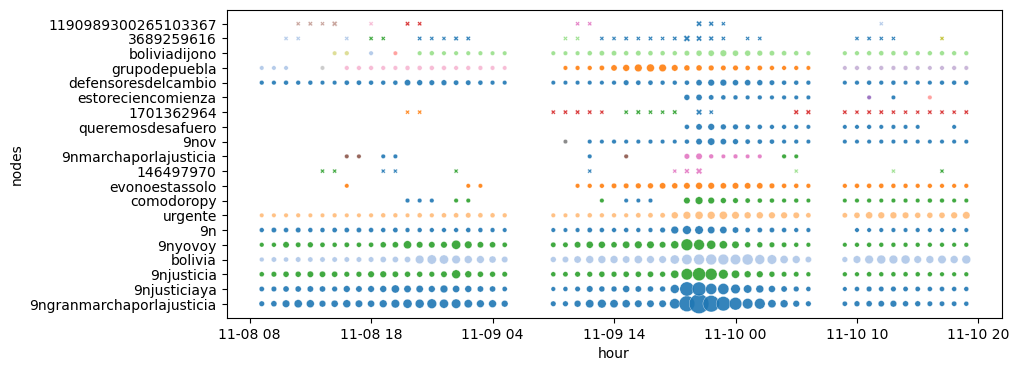

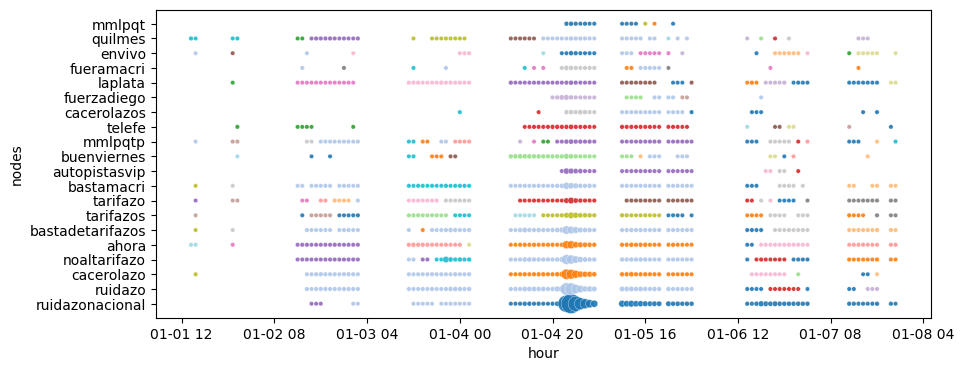

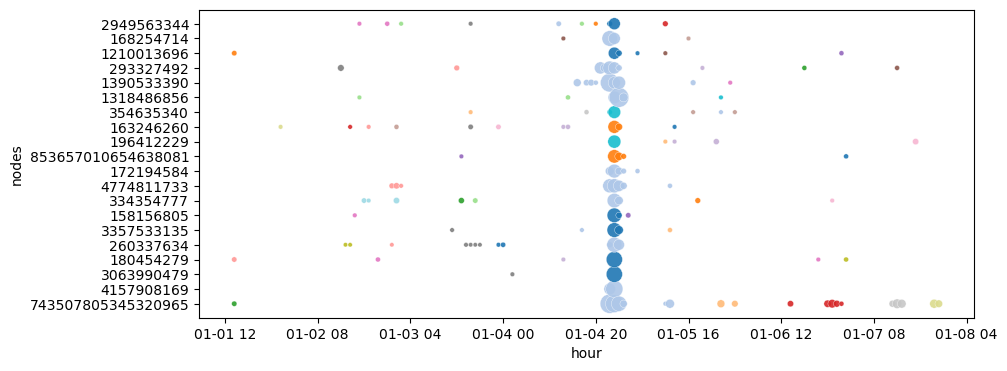

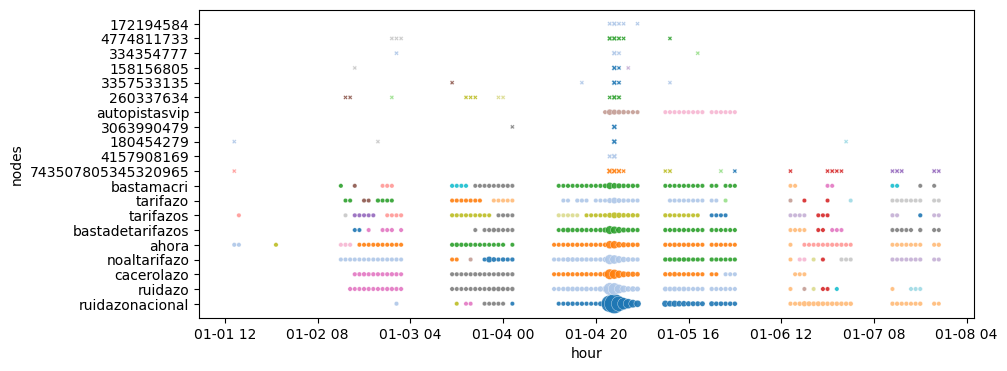

In [94]:



db = '9n'
for db in ['9n', 'no']:
    for net_type in ['hashNodes', 'userNodes', 'bipartite']:
        tg_comms_tmp_df = tg_comms_df[(tg_comms_df.net_type == net_type) &
                                      (tg_comms_df.db == db)].reset_index(drop = True)
        # plot_Node_freq(tg_comms_tmp_df)
        node_freq_and_tgComms_df = node_freq_df.merge(tg_comms_tmp_df, on=['hour', 'node', 'db'])


        tmp = node_freq_and_tgComms_df.groupby(['hour', 'tg_com']).size().reset_index().rename(columns={0:'tg_com_size'})
        node_freq_and_tgComms_df =  node_freq_and_tgComms_df.merge(tmp, on=['hour', 'tg_com'])

        pd.set_option('future.no_silent_downcasting', True)
        if 'bipartite' in net_type:
            nodes = ['hashtag', 'user']
            comp_col = 'bip_community'
        elif net_type == 'hashNodes':
            nodes = ['hashtag']
            comp_col = 'tg_com'
        else:
            nodes = ['user']
            comp_col = 'user_community'
            
        n_top_nodes = 20

        hour = highest_nest_df.loc[(highest_nest_df.net_type == 'bipartite_trimed') &
                                (highest_nest_df.db == db), 'hour'].iloc[0]

        reference_nodes_dec = node_freq_and_tgComms_df.loc[node_freq_and_tgComms_df.node_type.isin(nodes) &
                                (node_freq_and_tgComms_df.db == db) &
                                (node_freq_and_tgComms_df.hour == hour), : ].sort_values('freq', 
                                                ascending = False).reset_index(drop=True)['node'][:n_top_nodes].to_dict()

        reference_nodes = {y: x for x, y in reference_nodes_dec.items()}



        def get_node_freq_community_per_hour(group):
            group = group.sort_values(comp_col+'_size', ascending=False).reset_index().rename(columns={'index':'order_' + comp_col})
            return group.loc[group.node.isin(reference_nodes.keys()), ['node','node_type', 'freq', 'tg_com', 'tg_com_size']]

        df = node_freq_and_tgComms_df.loc[(node_freq_and_tgComms_df.db == db) &
                            (node_freq_and_tgComms_df.hour.isin(dates.hour.tolist() + [hour])) &
                            (node_freq_and_tgComms_df.node.isin(reference_nodes.keys())), 
                            :]
        # df = df.dropna(subset=comp_col, ).reset_index(drop=True)

        df['y_coord'] = df.node.replace(reference_nodes)
        # df[comp_col] = df[comp_col].astype(object)
        df['hour'] = df['hour'].astype(int)
        df['y_coord'] = df['y_coord'].astype(int)
        df['freq'] = df['freq'].astype(int)


        df['comp'] = df['tg_com']

        fig, ax = plt.subplots(1,1, figsize = [10, 4])

        sns.scatterplot(data = df, 
                        x = 'hour', y = 'y_coord', 
                        hue = 'comp',
                        style='node_type', size='freq', 
                        sizes=(10, 200), legend=False,
                        palette = 'tab20',
                        ax = ax,
                        alpha =.9)

        ax.ticklabel_format(useOffset=False)
        ax.set_yticks(np.arange(20));

        tick_labels = [reference_nodes_dec[p] for p in range(20)]

        new_xticklabels = [pd.to_datetime( int(hour.get_text()) * 3600, unit='s').strftime('%m-%d %H') for hour in ax.get_xticklabels()]

        ax.set_xticklabels(new_xticklabels);
        ax.set_yticklabels(tick_labels);
        ax.set_ylabel('nodes')


In [85]:
reference_nodes_dec

{0: '9ngranmarchaporlajusticia',
 1: '9njusticiaya',
 2: '9njusticia',
 3: 'bolivia',
 4: '9nyovoy',
 5: '9n',
 6: 'urgente',
 7: 'comodoropy',
 8: 'evonoestassolo',
 9: '9nmarchaporlajusticia',
 10: '9nov',
 11: 'queremosdesafuero',
 12: 'estoreciencomienza',
 13: 'defensoresdelcambio',
 14: 'grupodepuebla',
 15: 'boliviadijono',
 16: 'fichalimpialovamosalograr',
 17: 'evorenunciaya',
 18: 'estorecienempieza',
 19: 'larebeliondelosmansos'}

In [65]:
dates

,db,hour,mod,nest,n_comp,total_nr_of_hashs,total_nr_of_users,total_nr_of_nodes,nr_of_hashs_in_giant_c,nr_of_users_in_giant_c,nr_of_nodes_in_giant_c,is_bipartite
0,9n,437001,0.684116,0.034037,5,95,257,352,91,245,336,True
0,9n,437002,0.653276,0.033726,5,139,452,591,133,444,577,True
0,9n,437003,0.641575,0.036560,9,147,571,718,138,553,691,True
0,9n,437004,0.656220,0.035925,9,163,626,789,153,599,752,True
0,9n,437005,0.641955,0.041942,5,172,597,769,168,589,757,True
...,...,...,...,...,...,...,...,...,...,...,...,...
0,no,429688,0.844535,0.017416,16,72,174,246,50,128,178,True
0,no,429689,0.852125,0.017452,15,66,167,233,48,128,176,True
0,no,429690,0.837257,0.015130,15,70,176,246,54,138,192,True
0,no,429693,0.812836,0.012915,14,77,171,248,64,137,201,True


In [72]:
node_freq_and_tgComms_df.hour

Series([], Name: hour, dtype: int32)

In [66]:
dates.hour.tolist() + [hour]

[437001,
 437002,
 437003,
 437004,
 437005,
 437006,
 437007,
 437008,
 437009,
 437010,
 437011,
 437012,
 437013,
 437014,
 437015,
 437016,
 437017,
 437018,
 437019,
 437020,
 437021,
 437025,
 437026,
 437027,
 437028,
 437029,
 437030,
 437031,
 437032,
 437033,
 437034,
 437035,
 437036,
 437037,
 437038,
 437039,
 437040,
 437041,
 437042,
 437043,
 437044,
 437045,
 437046,
 437049,
 437050,
 437051,
 437052,
 437053,
 437054,
 437055,
 437056,
 437057,
 437058,
 437059,
 429542,
 429543,
 429551,
 429552,
 429565,
 429566,
 429567,
 429568,
 429569,
 429570,
 429571,
 429572,
 429573,
 429574,
 429575,
 429576,
 429577,
 429578,
 429589,
 429590,
 429591,
 429592,
 429593,
 429594,
 429595,
 429596,
 429597,
 429598,
 429599,
 429600,
 429601,
 429602,
 429611,
 429612,
 429613,
 429614,
 429615,
 429616,
 429617,
 429618,
 429619,
 429620,
 429621,
 429622,
 429623,
 429624,
 429625,
 429626,
 429627,
 429628,
 429629,
 429635,
 429636,
 429637,
 429638,
 429639,
 429640,
 

In [63]:
node_freq_and_tgComms_df.loc[(node_freq_and_tgComms_df.db == db) &
                             (node_freq_and_tgComms_df.hour.isin(dates.hour.tolist() + [hour])),
                          :]

,node_type,node,freq,db,hour,hash_comp,hash_comp_size,user_comp,user_comp_size,bip_comp,bip_comp_size,tg_com,net_type,tg_com_size


In [62]:
node_freq_and_tgComms_df.loc[(node_freq_and_tgComms_df.db == db) &
                             (node_freq_and_tgComms_df.hour.isin(dates.hour.tolist() + [hour])),
                          :].groupby('hour').apply(lambda g: get_node_freq_community_per_hour(g)).reset_index().drop(columns = 'level_1')

C:\Users\neuro\AppData\Local\Temp\ipykernel_20968\140526539.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  :].groupby('hour').apply(lambda g: get_node_freq_community_per_hour(g)).reset_index().drop(columns = 'level_1')


ValueError: cannot insert hour, already exists

In [53]:
highest_nest_df.loc[(highest_nest_df.net_type == 'bipartite_trimed') &
                          (highest_nest_df.db == db), 'hour']

Series([], Name: hour, dtype: int64)

In [54]:
highest_nest_df

,net_type,db,hour
0,bipartite,noAlt,429624
1,bipartite,9n,437037
0,bipartite_trimed,noAlt,429624
1,bipartite_trimed,9n,437037
0,hashNodes,noAlt,429624
1,hashNodes,9n,437045
0,userNodes,noAlt,429624
1,userNodes,9n,437037
